---
# Solving an ODE and adding moise to the answer to find the curve-fit function as practice
---

Simulation complete. Calculated 200 data points.

--- Preview of Experiment Data ---
     Time_s  Displacement_Clean_m  Displacement_Noisy_m  Velocity_m_s
0  0.000000              1.000000              0.927314      0.000000
1  0.100503              0.975022              1.314778     -0.493319
2  0.201005              0.901995              0.575243     -0.952259
3  0.301508              0.785511              0.704014     -1.354653
4  0.402010              0.632235              0.622649     -1.681593

Data saved successfully to 'vibration_data.csv'

--- Curve Fit Results ---
Calculated Decay Rate (b): 0.1086
Calculated Frequency (w):  2.1963


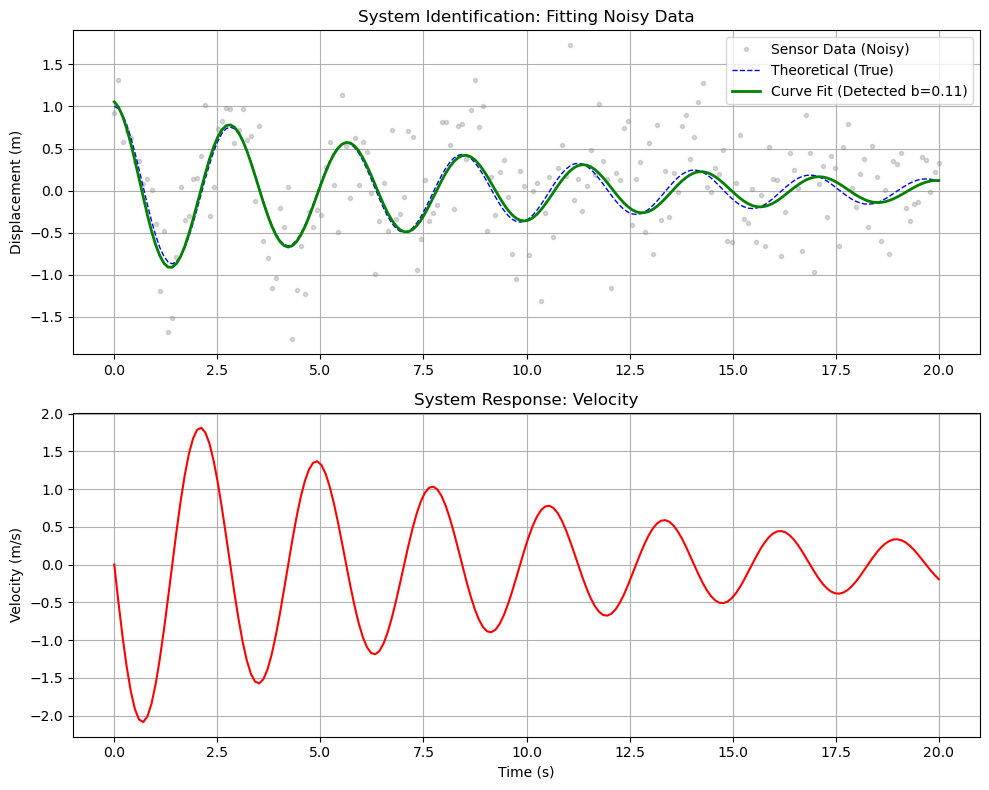

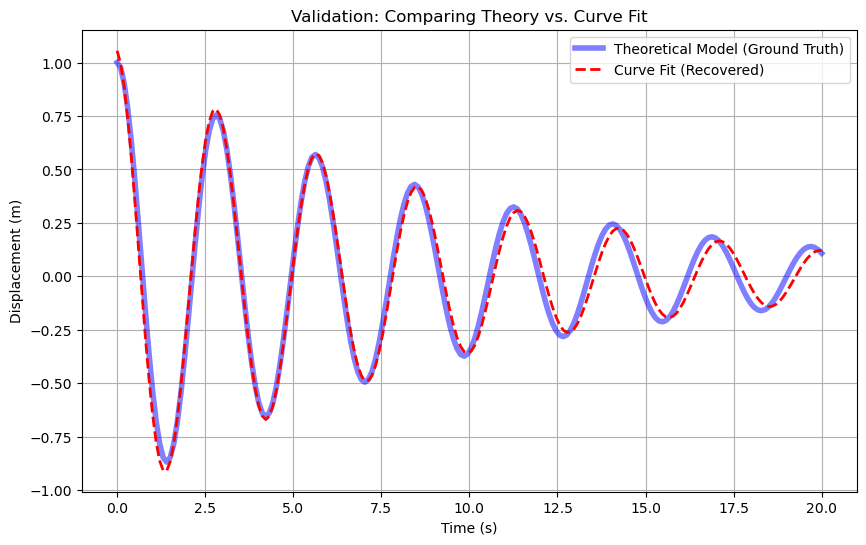

In [ ]:
import sympy as sp
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

m, c, k, t = sp.symbols('m c k t')
x = sp.Function('x')(t)
eq = m*x.diff(t, 2) + c*x.diff(t) + k*x
solve = sp.dsolve(eq, x)

def system_model(current_state, t, m, c, k):
    # Unpack the current state
    x = current_state[0] # Displacement
    v = current_state[1] # Velocity

    # 1. dx/dt is simply velocity
    dxdt = v  
    
    # 2. dv/dt is acceleration (Force / mass)
    # The ANSWER:
    dvdt = (-c * v - k * x) / m 

    return [dxdt, dvdt]

# --- Parameters ---
m = 10.0   # Mass (kg)
k = 50.0   # Spring constant (N/m)
c = 2.0    # Damping coefficient (Ns/m) -> Low damping means it will oscillate

# --- Initial Conditions ---
x0 = 1.0   # Initial displacement (1 meter stretched)
v0 = 0.0   # Initial velocity (released from rest)
initial_state = [x0, v0]

# --- Time Array ---
# Create 200 time steps from 0 to 20 seconds
t = np.linspace(0, 20, 200) 

# --- Solve the ODE ---
# arguments=(m, c, k) passes our constants to the system_model function
solution = odeint(system_model, initial_state, t, args=(m, c, k))

# The solution is a matrix where:
# Column 0 is Displacement (x)
# Column 1 is Velocity (v)
displacement = solution[:, 0]
velocity = solution[:, 1]

print(f"Simulation complete. Calculated {len(displacement)} data points.")


# 1. Simulate Sensor Noise
# We assume the sensor has a standard deviation (error) of 0.05 meters
noise_level = 0.5
# Generate random noise for every time step
sensor_noise = np.random.normal(0, noise_level, len(t))

# 2. Add noise to the clean displacement
noisy_displacement = displacement + sensor_noise

# 3. Create a DataFrame (Think of this like an Excel sheet in Python)
df = pd.DataFrame({
    'Time_s': t,
    'Displacement_Clean_m': displacement,
    'Displacement_Noisy_m': noisy_displacement,
    'Velocity_m_s': velocity
})

# Display the first 5 rows to check our work
print("\n--- Preview of Experiment Data ---")
print(df.head())

# 4. Save to CSV
# index=False means we don't save the row numbers (0, 1, 2...)
df.to_csv('vibration_data.csv', index=False)
print("\nData saved successfully to 'vibration_data.csv'")



# 1. Define the mathematical model we want to fit
# A = Amplitude, b = Decay rate, w = Angular frequency, phi = Phase shift
def target_func(t, A, b, w, phi):
    return A * np.exp(-b * t) * np.cos(w * t + phi)

# 2. Provide an initial guess (p0)
# This helps the computer start looking in the right place.
# Guess: Amp=1, Decay=0.1, Freq=2.0, Phase=0
initial_guess = [1.0, 0.1, 2.0, 0.0]

# 3. Perform the Curve Fit
# We pass the Noisy data to find the best smooth line
# popt = "Optimal Parameters" (the calculated A, b, w, phi)
# pcov = "Covariance" (how accurate the fit is)
popt, pcov = curve_fit(target_func, 
                       df['Time_s'], 
                       df['Displacement_Noisy_m'], 
                       p0=initial_guess)

# Extract the calculated values
A_fit, b_fit, w_fit, phi_fit = popt
print(f"\n--- Curve Fit Results ---")
print(f"Calculated Decay Rate (b): {b_fit:.4f}")
print(f"Calculated Frequency (w):  {w_fit:.4f}")

# 4. Generate the "Fitted Curve" data points for plotting
df['Displacement_Fitted'] = target_func(df['Time_s'], *popt)


# --- Plotting Results ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# 1. Top Plot: Displacement
# Plot the noisy data as dots
ax1.plot(df['Time_s'], df['Displacement_Noisy_m'], 
         color='gray', linestyle='none', marker='.', alpha=0.3, label='Sensor Data (Noisy)')

# Plot the Clean Theoretical Model (Blue Dashed)
ax1.plot(df['Time_s'], df['Displacement_Clean_m'], 
         color='blue', linestyle='--', linewidth=1, label='Theoretical (True)')

# --- THE NEW PART ---
# Plot the Curve Fit (Green Solid)
ax1.plot(df['Time_s'], df['Displacement_Fitted'], 
         color='green', linewidth=2, label=f'Curve Fit (Detected b={b_fit:.2f})')
# --------------------

ax1.set_title('System Identification: Fitting Noisy Data')
ax1.set_ylabel('Displacement (m)')
ax1.legend()
ax1.grid(True)

# 2. Bottom Plot: Velocity
ax2.plot(df['Time_s'], df['Velocity_m_s'], color='red')
ax2.set_title('System Response: Velocity')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Velocity (m/s)')
ax2.grid(True)

plt.tight_layout()
plt.show()
# --- Model Validation Plot (Clean vs Fitted) ---
plt.figure(figsize=(10, 6))

# 1. Plot the "Perfect" Theoretical Model (Thick Blue Line)
plt.plot(df['Time_s'], df['Displacement_Clean_m'], 
         color='blue', linewidth=4, alpha=0.5, label='Theoretical Model (Ground Truth)')

# 2. Plot the "Curve Fit" Model (Thin Red Dashed Line)
# We make this line thinner and dashed so you can see if it lies perfectly on top of the blue line
plt.plot(df['Time_s'], df['Displacement_Fitted'], 
         color='red', linestyle='--', linewidth=2, label='Curve Fit (Recovered)')

plt.title('Validation: Comparing Theory vs. Curve Fit')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.legend()
plt.grid(True)
plt.show()